Tutorial: Image processing
==========================

Introduction
----------

Motivation: Medical images are becoming increasingly important in diagnosis and planning interventions. Sometimes images can be poor quality and/or it can be difficult for clinicians to clearly make out the features they are interested in. Image processing operations can detect or highlight features of interest. They can also act as important preprocessing steps for higher-level operations such as image segmentation or registration. 

In this tutorial we will investigate a range of different image processing operations and see how they can be easily applied using Python. We will see how relatively simple processing operations can be applied to images to improve contrast, highlight and detect edges and reduce noise.

Image I/O and Display
----------------------
To familiarise yourself with reading in and displaying images, try out functions `imread()`, `imshow()` using the package [Scikit Image](https://scikit-image.org/) on some of the images provided.

In [4]:
from skimage import io

img_ct = io.imread('CT.tif', as_gray = True)
io.imshow(img_ct)

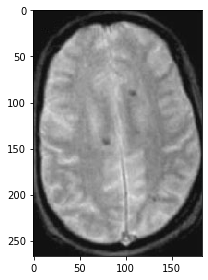

In [5]:
img_brain = io.imread('MR_brain.tif', as_gray = True)
io.imshow(img_brain)

Spatial domain processing: point processing operations
=============

Point processing operations use only the old intensity of each pixel to compute the new intensity. They apply an 'intensity mapping' function to compute the new intensity from the old one. One of the most common point processing operations is known as 'gamma correction'.

Exercise
--------

Read in the image `CT.tif` - this is a CT scout image (an X-ray performed to facilitate planning of a CT scan). The image contrast is quite poor around the shoulders and inside the chest. Apply a gamma correction operation with a value of 0.4 for gamma to improve visualisation. What happens if you apply a gamma correction with gamma > 1?

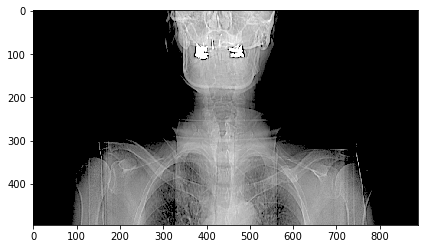

In [20]:
from skimage import exposure

# Gamma > 1 makes the image really dark where the opposite is true if gamma < 1
io.imshow(exposure.adjust_gamma(img_ct, 0.4), cmap='gray')

More flexible point processing operations can be achieved using a piecewise linear approach. These can be especially useful if the intensity range that needs 'stretching' lies in the middle of the overall intensity range.

Exercise
-------

Read in the image `MR_brain.tif` and apply a piecewise linear intensity mapping to it, such that the middle half of the intensity range (i.e. from 25% to 75% of the maximum intensity) maps to the full intensity range in the output image.

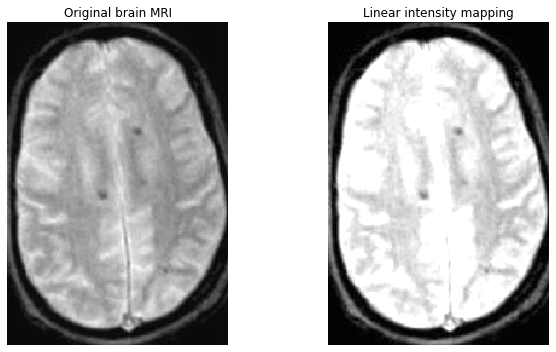

In [17]:
import matplotlib.pyplot as plt

# Calculate the intensity percentiles of MR brain image
v_min, v_max = np.percentile(img_brain, (0.25, 75.0))

img_brain_corrected = exposure.rescale_intensity(img_brain, in_range=(v_min, v_max))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(img_brain, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original brain MRI')

ax[1].imshow(img_brain_corrected, cmap=plt.cm.gray)
ax[1].set_title('Linear intensity mapping')
ax[1].axis('off')

plt.tight_layout()

Spatial domain processing: image histograms
=========

Image histograms summarise the distribution of intensities in an image. An alternative contrast enhancement technique based on histograms is known as 'histogram equalisation'. This defines an intensity mapping that automatically stretches the image histogram to make it as 'equal' and smooth as possible.

Exercise
------

First of all view the histogram for the original `CT.tif` image. Then view the histogram for the gamma corrected image you created in exercise 1.

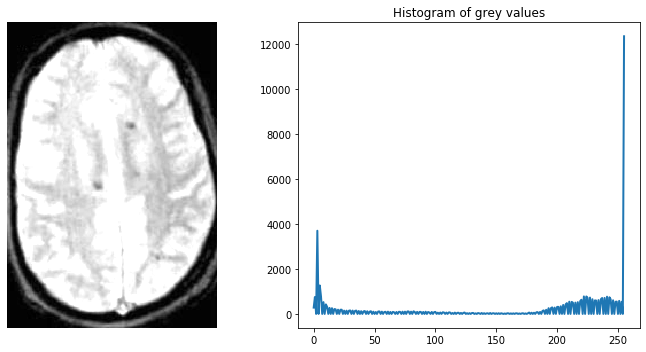

In [19]:
from skimage import exposure
from skimage.exposure import histogram
import numpy as np

hist, hist_centers = histogram(img_brain_corrected)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(img_brain_corrected, cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].plot(hist_centers, hist, lw=2)
ax[1].set_title('Histogram of grey values')

plt.tight_layout()

Next, read in the `fluoro.tif` image - this is a fluoroscopic X-ray image with relatively poor contrast because of its low dose. Display the image and its associated histogram. Then, perform a histogram equalisation operation on this image. Finally, view the resulting histogram-equalised image, its associated histogram and its intensity mapping function.

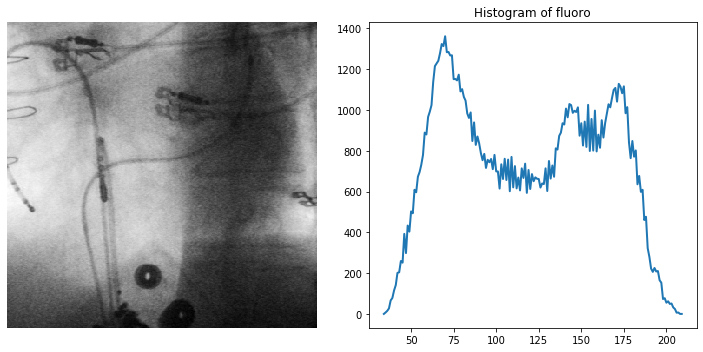

In [21]:
img_fluoro = io.imread('fluoro.tif', as_gray = True)

hist, hist_centers = histogram(img_fluoro)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(img_fluoro, cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].plot(hist_centers, hist, lw=2)
ax[1].set_title('Histogram of fluoro')

plt.tight_layout()

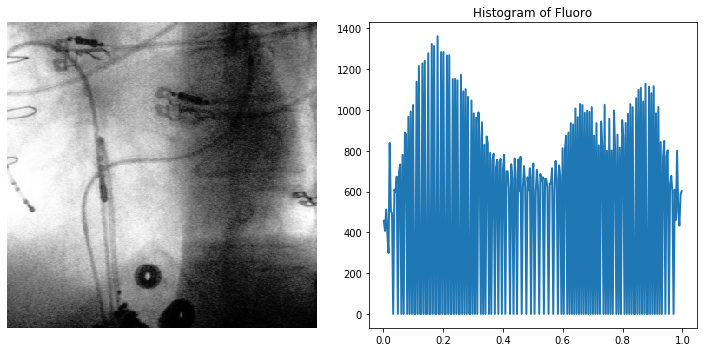

In [23]:
img_fluoro_eq = exposure.equalize_hist(img_fluoro)

hist, hist_centers = histogram(img_fluoro_eq)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(img_fluoro_eq, cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].plot(hist_centers, hist, lw=2)
ax[1].set_title('Histogram of Fluoro')

plt.tight_layout()

Spatial domain processing: mask processing operations - edge detection
======

As well as denoising, one of the main applications of mask processing operations is to detect or highlight features such as edges. Edge detection filters produce a new image in which there are bright intensities where there were edges in the original image. Edge enhancement filters produce a new image which is similar to the original image but with sharper looking edges. In this exercise we will look at some common edge detection and enhancement filters.

Exercise
----

One of the most common types of edge detection filters is the Sobel filters. Read in the image `MR_heart.tif`, then create and apply vertical and horizontal Sobel edge detection filters. These should produce images in which vertical and horizontal edges respectively are detected. Finally, produce a combined image which shows either vertical or horizontal edges.

Inspect the response of the horizontal filter closely, particularly at the bottom of the image. There should be a bright response at the edge of the image that does not correspond to any real edge. What do you think has caused this artefact? Look at the documentation for `imfilter` and find a way to remove this artefact.

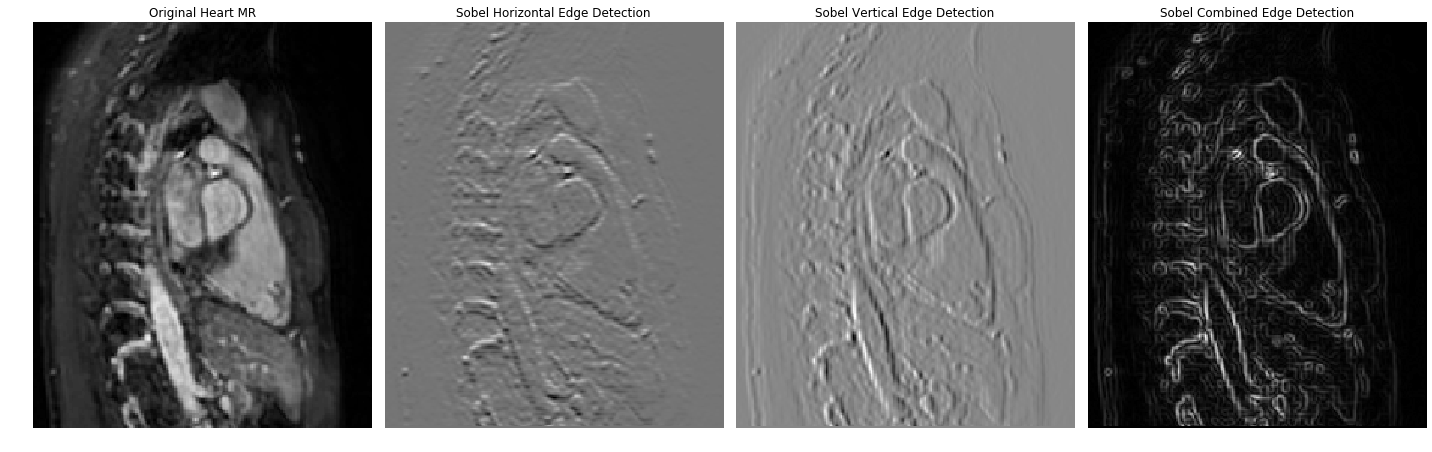

In [262]:
from skimage.filters import sobel_h, sobel_v

img_heart = io.imread('MR_heart.tif', as_gray = True)

edge_sobel_v = sobel_v(img_heart)
edge_sobel_h = sobel_h(img_heart)

edge_sobel = np.sqrt(edge_sobel_v**2 + edge_sobel_h**2)

# Or the function sobel can be used

fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True,
                       figsize=(20, 7))

ax[0].imshow(img_heart, cmap=plt.cm.gray)
ax[0].set_title('Original Heart MR')

ax[1].imshow(edge_sobel_h, cmap=plt.cm.gray)
ax[1].set_title('Sobel Horizontal Edge Detection')

ax[2].imshow(edge_sobel_v, cmap=plt.cm.gray)
ax[2].set_title('Sobel Vertical Edge Detection')

ax[3].imshow(edge_sobel, cmap=plt.cm.gray)
ax[3].set_title('Sobel Combined Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


Spatial domain processing: edge enhancement
======

One of the most common edge enhancement operations is the 'unsharp mask', which involves subtracting a scaled smoothed version of an image from itself. 
It can also be expressed as a convolution filter.


Exercise
-----

Create an unsharp mask filter and apply it to the `MR_heart.tif` image.

An alternative edge enhancement operation is the Laplacian filter. This filter actually computes the sum of second derivatives of the original image. It can be used for edge enhancement 
by adding the result of applying the filter to the original image.

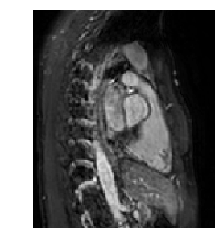

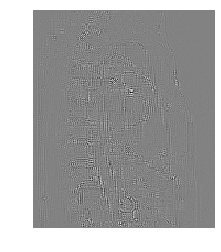

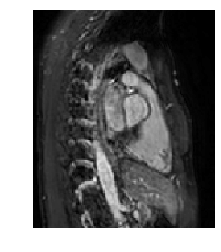

In [157]:
from skimage.filters import laplace

# img_heart properties
# a = img_heart.shape, img_heart.size, img_heart.min, img_heart.max

# for i in a:
#     print(i)
    
# img_heart.shape[1], img_heart.shape[0]

def convolve2d(image, kernel):
    '''
    This function which takes an image and a kernel and returns the convolution of them
    Args:
      image: a numpy array of size [image_height, image_width].
      kernel: a numpy array of size [kernel_height, kernel_width].
    Returns:
      a numpy array of size [image_height, image_width] (convolution output).
    '''
    
    kernel = np.flipud(np.fliplr(kernel))    # Flip the kernel
    output = np.zeros_like(image)            # convolution output
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + 2, image.shape[1] + 2))   
    image_padded[1:-1, 1:-1] = image
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y,x]=(kernel*image_padded[y:y+3,x:x+3]).sum()        
    return output

# kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

# image_sharpen = convolve2d(img_heart, kernel)

# plt.imshow(image_sharpen, cmap=plt.cm.gray)
# plt.axis('off')
# plt.show()

plt.imshow(img_heart, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

laplaced = laplace(img_heart)
laplaced = laplace(laplaced)

plt.imshow(laplaced, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

enhanced = laplaced + img_heart

plt.imshow(enhanced, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Exercise
------

First, create and apply a Laplacian filter to the `MR_heart.tif` image. Look at the result. Next, add this image to the
original image and compare the result to that obtained using an
unsharp mask. (Hint: you will need to negate the Laplacian filter created by Matlab before applying it.)

To avoid having to subtract the result of the Laplacian filter from the original image, you can create what is called a 'composite Laplacian' filter, which combines the result of the Laplacian 
operator and the original image in one step. Create and apply a composite Laplacian filter. Compare its coefficients with those of the unsharp mask.

Spatial domain processing: extra exercises (if you have time)
=====

% A.  Digital subtraction angiography (DSA) involves acquiring an X-ray
%     image without contrast injection (the 'mask') and acquiring a second
%     image with contrast injection, then subtracting the contrast image
%     from the mask. The idea is to highlight the blood vessels in which
%     the contrast fluid is present. Load in the 'mask.tif' and
%     'contrast.tif' images and compute a DSA image. (You may need to
%     apply some image processing operation to improve visualisation of
%     the DSA image.)
%
% B.  Study the effects of different denoising filters on reducing the
%     amount of noise in images. Read in the image 'MR_head.tif'
%     and generate several noisy images by adding different types of
%     noise to it: Gaussian noise, salt & pepper noise, Poisson noise
%     and speckle. For each noisy image, use the average filter and the
%     median filter to reduce the noise. Based on your observations,
%     decide what is the best filter for reducing noise of each of the
%     4 types.
%
% C.  Look at the Matlab documentation for 'fspecial' and try out some
%     of the other special filters Matlab can create. Some of them also
%     allow you to tailor them to your needs by specifying extra parameters,
%     so you can try modifying these parameters to see the effects they
%     have on the resulting images.
%
%% 5. Frequency domain processing: smoothing
%
%    Many image processing operations can be performed either in the
%    spatial domain or the frequency domain. Write a Matlab program that
%    reads in an image, and performs a smoothing operation on the image
%    using both approaches. Use your knowledge of the convolution theorem
%    to apply the equivalent frequency domain operation to a spatial domain
%    smoothing operation. The program should display the original and
%    both smoothed images.

%% Frequency domain processing: extra exercises (if you have time)
%
% D. Write a Matlab function that performs an ideal lowpass filter on
%    a Fourier transform. Modify your answer to Exercise 5 to use your
%    new function when performing the frequency domain operation. In
%    addition to the results displayed in Exercise 5, your new program
%    should also display the difference between the two smoothed images,
%    the original Fourier transform and the Fourier transform after
%    processing using your ideal filter.
%
% E. Frequency domain processing can be particularly useful for reducing
%    the effects of structured noise. The file 'confocalimage.gif' contains
%    a confocal microscopy image that has been corrupted by such structured
%    noise (visible as horizontal lines across the image). If you view the
%    Fourier transform of this image you will see the presence of this
%    structured noise as an artefact in the Fourier transform.
%    Write a Matlab program that reads in the 'confocalimage.gif' image,
%    displays its Fourier transform and then allows the user to
%    interactively define a region of the Fourier transform to be set to
%    zero. The mask defined in this way should then be applied in the
%    frequency domain to process the image. Use your program to eliminate
%    the structured noise from the image. Your final program should display:
%    - the original image
%    - its Fourier transform
%    - the mask
%    - the masked Fourier transform
%    - the processed image (in the spatial domain)
%    - an image showing the difference between the original and processed
%      images